## (In Progress)

### Note: The code is setup in a way that you can easily run the notebook on colab with minimal changes
### TFRecords Dataset: https://www.kaggle.com/ks2019/happywhale-tfrecords-v1
### Code for generating TFRecords: https://www.kaggle.com/ks2019/happywhale-tfrecords

In [ ]:
import os
IS_COLAB = not os.path.exists('/kaggle/input')
print(IS_COLAB) 

True


In [ ]:
# !pip install tfimm
# !pip install timm
# import tfimm
# print(tfimm.list_models(pretrained="timm"))

In [ ]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.84.103.226:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.84.103.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.84.103.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
else:
  from kaggle_datasets import KaggleDatasets

Mounted at /content/drive


In [ ]:
!pip install -q efficientnet
!pip install tensorflow_addons
import re
import os
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
# from kaggle_datasets import KaggleDatasets

     |████████████████████████████████| 50 kB 2.1 MB/s 
     |████████████████████████████████| 1.1 MB 5.7 MB/s 


## Config

In [ ]:
save_dir = '.'
EXPERIMENT = 0
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)
if IS_COLAB:
    save_dir = f'/content/drive/MyDrive/model/backfin/fold4_0326_b6/'
    !mkdir -p {save_dir}

20220326-110657


In [ ]:
class config:
    
    
    SEED = 42
    FOLD_TO_RUN = 4
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = 27
    
    
    ### Dataset
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 640
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1' #'effnetv1'  
    EFF_NET = 6
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    # head = 'arcface_subcenter'
    EPOCHS = 60
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 100
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [ ]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b6


In [ ]:
with open(config.save_dir+'/config_s2.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [ ]:
'''背鳍数据集'''
GCS_PATH = 'gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4'  # Get GCS Path from kaggle notebook if GCS Path is expired

'''身体数据集'''
# GCS_PATH = 'gs://kds-039dbc013d9c021f5e790e4ff22108cba3171a6a42ad7001cf6a0dc0'  # Get GCS Path from kaggle notebook if GCS Path is expired


if not IS_COLAB:
    GCS_DS_PATH=KaggleDatasets().get_gcs_path('backfin-whale-tfrecords-crop-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4
5 5 51026 27956


## Data

In [ ]:
print(train_files)

['gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4/happywhale-2022-train-0-10206.tfrec'
 'gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4/happywhale-2022-train-1-10205.tfrec'
 'gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4/happywhale-2022-train-2-10205.tfrec'
 'gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4/happywhale-2022-train-3-10205.tfrec'
 'gs://kds-ee4e41d8200ac3838ed08c3974b2367316f7ab40f4268c11593be5f4/happywhale-2022-train-4-10205.tfrec']


In [ ]:
def random_float(minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(
        [], minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd
def choice(p, image1,  image2):
    rnd = random_float()
    image = tf.where(rnd <= p, image1, image2)
    # mask = tf.where(rnd <= p, mask1, mask2)
    return image
def RandomRotate(Degree,p):
    def _do_RandomRotate(image):
        degree = random.uniform(-Degree, Degree)
        aug_image = tfa.image.rotate(image, degree * math.pi / 180)

        return choice(p, aug_image,  image)
    return _do_RandomRotate

def mirror_boundary(v, max_v):
    # v % (max_v*2.0-2.0) ==> v % (512*2-2) ==> [0..1022]
    # [0..1022] - (max_v-1.0) ==> [0..1022] - 511 ==> [-511..511]
    # -1.0 * abs([-511..511]) ==> [-511..0]
    # [-511..0] + max_v - 1.0 ==> [-511..0] + 511 ==> [0..511]
    mirror_v = -1.0 * tf.math.abs(
        v % (max_v*2.0-2.0) - (max_v-1.0)) + max_v-1.0
    return mirror_v

def clip_boundary(v, max_v):
    clip_v = tf.clip_by_value(v, 0.0, max_v-1.0)
    return clip_v

def interpolate_bilinear(image, map_x, map_y):
    def _gather(image, map_x, map_y):
        map_stack = tf.stack([map_x, map_y]) # [ 2, height, width ]
        map_indices = tf.transpose(
            map_stack, perm=[1, 2, 0])       # [ height, width, 2 ]
        map_indices = tf.cast(map_indices, dtype=tf.int32)
        gather_image = tf.gather_nd(image, map_indices)
        return gather_image
    
    ll = _gather(image, tf.math.floor(map_x), tf.math.floor(map_y))
    lr = _gather(image, tf.math.ceil(map_x), tf.math.floor(map_y))
    ul = _gather(image, tf.math.floor(map_x), tf.math.ceil(map_y))
    ur = _gather(image, tf.math.ceil(map_x), tf.math.ceil(map_y))
    
    fraction_x = tf.expand_dims(map_x % 1.0, axis=-1) # [h, w, 1]
    int_l = (lr - ll) * fraction_x + ll
    int_u = (ur - ul) * fraction_x + ul
    
    fraction_y = tf.expand_dims(map_y % 1.0, axis=-1) # [h, w, 1]
    interpolate_image = (int_u - int_l) * fraction_y + int_l
    return interpolate_image

def remap(image, height, width, map_x, map_y, mode):
    assert \
        mode in ('mirror', 'constant'), \
        "mode is neither 'mirror' nor 'constant'"

    height_f = tf.cast(height, dtype=tf.float32)
    width_f = tf.cast(width, dtype=tf.float32)
    map_x = tf.reshape(map_x, shape=[height, width])
    map_y = tf.reshape(map_y, shape=[height, width])
    if mode == 'mirror':
        b_map_x = mirror_boundary(map_x, width_f)
        b_map_y = mirror_boundary(map_y, height_f)
    else:
        b_map_x = clip_boundary(map_x, width_f)
        b_map_y = clip_boundary(map_y, height_f)
        
    image_remap = interpolate_bilinear(image, b_map_x, b_map_y)
    
    if mode == 'constant':
        map_stack = tf.stack([map_x, map_y])
        map_indices = tf.transpose(map_stack, perm=[1, 2, 0])
        x_ge_0 = (0.0 <= map_indices[ : , : , 0])    # [h, w]
        x_lt_w = (map_indices[ : , : , 0] < width_f)
        y_ge_0 = (0.0 <= map_indices[ : , : , 1])
        y_lt_h = (map_indices[ : , : , 1] < height_f)
        inside_boundary = tf.math.reduce_all(
            tf.stack([x_ge_0, x_lt_w, y_ge_0, y_lt_h]), axis=0) # [h, w]
        inside_boundary = inside_boundary[ : , : , tf.newaxis]  # [h, w, 1]
        image_remap = tf.where(inside_boundary, image_remap, 0.0)

    return image_remap
def choice(p, image1,  image2):
    rnd = random_float()
    image = tf.where(rnd <= p, image1, image2)
    return image


def HorizontalFlip(p):
    def _do_horizontal_flip(image):
        aug_image = tf.image.flip_left_right(image)
        return choice(p, aug_image,  image)
    return _do_horizontal_flip

def RandomBrightness(max_delta, p):
    def _do_random_brightness(image):
        aug_image = tf.image.random_brightness(image, max_delta)
        return choice(p, aug_image,  image)
    return _do_random_brightness

def RandomContrast(lower, upper, p):
    def _do_random_contrast(image):
        aug_image = tf.image.random_contrast(image, lower, upper)
        return choice(p, aug_image,  image)
    return _do_random_contrast
def HueSaturationValue(
        hue_shift_limit, sat_shift_limit, val_shift_limit, p):
    def _do_hue_saturation_value(image):
        hsv_image = tf.image.rgb_to_hsv(image)
        hue_shift = random_float(-hue_shift_limit, +hue_shift_limit)
        sat_shift = random_float(1-sat_shift_limit, 1+sat_shift_limit)
        val_shift = random_float(1-val_shift_limit, 1+val_shift_limit)
        aug_image = tfa.image.adjust_hsv_in_yiq(image , delta_hue = hue_shift ,scale_saturation =sat_shift , scale_value = val_shift)
        return  choice(p, aug_image,  image)
    return _do_hue_saturation_value
    
def initUndistortRectifyMap(height, width, k, dx, dy):
    height = tf.cast(height, dtype=tf.float32)
    width = tf.cast(width, dtype=tf.float32)
    
    f_x = width
    f_y = height
    c_x = width * 0.5 + dx
    c_y = height * 0.5 + dy
    
    f_dash_x = f_x
    c_dash_x = (width - 1.0) * 0.5
    f_dash_y = f_y
    c_dash_y = (height - 1.0) * 0.5

    h_rng = tf.range(height, dtype=tf.float32)
    w_rng = tf.range(width, dtype=tf.float32)
    v, u = tf.meshgrid(h_rng, w_rng)
    
    x = (u - c_dash_x) / f_dash_x
    y = (v - c_dash_y) / f_dash_y
    x_dash = x
    y_dash = y
    
    r_2 = x_dash * x_dash + y_dash * y_dash
    r_4 = r_2 * r_2
    x_dash_dash = x_dash * (1 + k*r_2 + k*r_4)
    y_dash_dash = y_dash * (1 + k*r_2 + k*r_4)

    map_x = x_dash_dash * f_x + c_x
    map_y = y_dash_dash * f_y + c_y
    return map_x, map_y

def OpticalDistortion(distort_limit, shift_limit, p=1.0):
    def _do_optical_distortion(image):
        k = random_float(-distort_limit, distort_limit)
        dx = random_float(-shift_limit, shift_limit)
        dy = random_float(-shift_limit, shift_limit)
        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]
        map_x, map_y = initUndistortRectifyMap(
            height, width, k, dx, dy)
        aug_image = remap(
            image, height, width, map_x, map_y, mode='mirror')
    
        return choice(p, aug_image,  image)
    return _do_optical_distortion
def make_grid_distorted_maps(height, width, num_steps, xsteps, ysteps):
    def _make_maps_before_last(size, step, steps): # size=512, step=102,
                                                   # steps.shape=[num_steps]
        step_rep = tf.repeat(step, num_steps)  # [102, 102, 102, 102, 102]
        step_rep_f = tf.cast(step_rep, dtype=tf.float32)
        step_inc = step_rep_f * steps          # [102*s_0, ..., 102*s_4]
        cur = tf.math.cumsum(step_inc)         # [si_0, si_0 + si_1, ... ]
        zero = tf.zeros([1], dtype=tf.float32)
        prev = tf.concat([ zero, cur[ :-1] ], axis=0) # [0, c_0, ..., c_3]
        prev_cur = tf.stack([prev, cur])       # [[p_0, p_1, ...], [c_0, c_1, ...]]
        ranges = tf.transpose(prev_cur)        # [[p_0, c_0], [p_1, c_1], ... ]

        def _linspace_range(rng):
            return tf.linspace(rng[0], rng[1], step)
 
        maps_stack = tf.map_fn(_linspace_range, ranges)
        maps = tf.reshape(maps_stack, [-1])    # [-1] flatten into 1-D
        return maps
    
    def _make_last_map(size, step, last_start):
        last_step = size - step * num_steps  # 512 - 102*5 = 2 
        size_f = tf.cast(size, dtype=tf.float32)
        last_map = tf.linspace(last_start, size_f-1.0, last_step)
        return last_map
    
    def _make_distorted_map(size, steps):
        step = size // num_steps               # step=102 
        maps_before_last = _make_maps_before_last(size, step, steps[ :-1 ])
        last_map = _make_last_map(size, step, maps_before_last[-1])
        distorted_map = tf.concat([maps_before_last, last_map], axis=0)
        return distorted_map

    xx = _make_distorted_map(width, xsteps)
    yy = _make_distorted_map(height, ysteps)
    map_y, map_x = tf.meshgrid(xx, yy)
    return map_x, map_y

def GridDistortion(num_steps, distort_limit, p=1.0):
    def _do_grid_distortion(image):
        xsteps = tf.random.uniform(
            [num_steps + 1],
            minval=1.0 - distort_limit,
            maxval=1.0 + distort_limit)
        ysteps = tf.random.uniform(
            [num_steps + 1],
            minval=1.0 - distort_limit,
            maxval=1.0 + distort_limit)

        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]
        map_x, map_y = make_grid_distorted_maps(
            height, width, num_steps, xsteps, ysteps)
        aug_image = remap(
            image, height, width, map_x, map_y, mode='mirror')

        return choice(p, aug_image,  image)
    return _do_grid_distortion
def affine_transform(height, width, tx, ty, z, theta):
    cx = (width - 1.0) * 0.5
    cy = (height - 1.0) * 0.5
    
    center_shift_mat = tf.convert_to_tensor([
        [1.0, 0.0, -cx],
        [0.0, 1.0, -cy],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = center_shift_mat
    
    rot_rad = -2.0 * math.pi * theta / 360.0
    roration_mat = tf.convert_to_tensor([
        [tf.math.cos(rot_rad), tf.math.sin(rot_rad), 0.0],
        [-tf.math.sin(rot_rad), tf.math.cos(rot_rad), 0.0],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(roration_mat, trans_mat)
    
    shift_mat = tf.convert_to_tensor([
        [1.0, 0.0, cx - tx],
        [0.0, 1.0, cy - ty],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(shift_mat, trans_mat)

    zoom_mat = tf.convert_to_tensor([
        [1.0 / z, 0.0, 0.0],
        [0.0, 1.0 / z, 0.0],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(zoom_mat, trans_mat)
    
    h_rng = tf.range(height, dtype=tf.float32)
    w_rng = tf.range(width, dtype=tf.float32)
    y, x = tf.meshgrid(h_rng, w_rng)
    x = tf.reshape(x, [-1])
    y = tf.reshape(y, [-1])
    ones = tf.ones_like(x)
    coord_mat = tf.stack([x, y, ones])
    
    res_mat = tf.linalg.matmul(trans_mat, coord_mat)
    map_x = res_mat[0]
    map_y = res_mat[1]
    return map_x, map_y
def ShiftScaleRotate(
        shift_limit, scale_limit, rotate_limit, p):
    def _do_shift_scale_rotate(image):
        image_shape = tf.shape(image)
        height_i = image_shape[0]
        width_i = image_shape[1]
        height_f = tf.cast(height_i, dtype=tf.float32)
        width_f = tf.cast(width_i, dtype=tf.float32)
        tx = width_f * random_float(-shift_limit, shift_limit)
        ty = height_f * random_float(-shift_limit, shift_limit)
        z = random_float(1.0 - scale_limit, 1.0 + scale_limit)
        theta = random_float(-rotate_limit, rotate_limit)

        map_x, map_y = affine_transform(
            height_f, width_f, tx, ty, z, theta)
        aug_image = remap(
            image, height_i, width_i, map_x, map_y, mode='constant')

        return choice(p, aug_image,  image)
    return _do_shift_scale_rotate
def randints(shape, minval, maxval):
    # maxval+1 to include maxval for the result.
    # generated range is [minval, maxval) (maxval is not included)
    return tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval+1, dtype=tf.int32)

def make_range_masks(size, starts, ends):
    indice = tf.range(size, dtype=tf.int32)
    start_masks = (
        starts[ : , tf.newaxis] <= indice[  tf.newaxis, : ])
    end_masks = (
        indice[ tf.newaxis, : ] <= ends[ : , tf.newaxis])
    range_masks = start_masks & end_masks
    return range_masks

def make_region_mask(tops, lefts, bottoms, rights):
    row_masks = make_range_masks(config.IMAGE_SIZE, tops, bottoms)
    col_masks = make_range_masks(config.IMAGE_SIZE, lefts, rights)
    region_masks = \
        row_masks[ : , : , tf.newaxis ] & \
        col_masks[ : , tf.newaxis, : ]
    region_mask = tf.math.reduce_any(region_masks, axis=0)
    region_mask = region_mask[ : , : , tf.newaxis]
    return region_mask

def Cutout(num_cuts, mask_factor, p):
    def _do_cutout(image):
        image_shape = tf.shape(image)
        height_i = image_shape[0]
        width_i = image_shape[1]
        height_f = tf.cast(height_i, dtype=tf.float32)
        width_f = tf.cast(width_i, dtype=tf.float32)
        cut_h = tf.cast(height_f * mask_factor, dtype=tf.int32)
        cut_w = tf.cast(width_f * mask_factor, dtype=tf.int32)

        y_centers = randints([num_cuts], 0, config.IMAGE_SIZE - 1)
        x_centers = randints([num_cuts], 0, config.IMAGE_SIZE - 1)
        tops = tf.math.maximum(y_centers - cut_h//2, 0)
        lefts = tf.math.maximum(x_centers - cut_w//2, 0)
        bottoms = tf.math.minimum(tops + cut_h, height_i - 1)
        rights = tf.math.minimum(lefts + cut_w, width_i - 1)

        cut_region = make_region_mask(tops, lefts, bottoms, rights)
        mask_value = tf.constant(0.0, dtype=tf.float32)
        aug_image = tf.where(cut_region, mask_value, image)
        return choice(p, aug_image,  image)
    return _do_cutout
def OneOf(trans1, trans2, p):
    def _do_one_of(image):
        image1 = trans1(image)
        image2 = trans2(image)
        aug_image = choice(
            0.5, image1,  image2)
        return aug_image
    return _do_one_of


In [ ]:
random_rotate = RandomRotate(Degree= 25,p=0.5)
# horizontal_flip = HorizontalFlip(p=0.5)
# random_brightness = RandomBrightness(max_delta=0.2, p=0.5)
# random_contrast = RandomContrast(lower=0.8, upper=1.2, p=0.5)
# optical_distortion = OpticalDistortion(distort_limit=1.0, shift_limit=0.05, p=0.5)
# grid_distortion = GridDistortion(num_steps=5, distort_limit=1.0, p=0.5)
# one_of_opt_grid_distortion = OneOf(optical_distortion, grid_distortion, p=0.5)
# hue_saturation_value = HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.3,val_shift_limit=0.2, p=0.5)
# shift_scale_rotate = ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5)
# cut_out = Cutout(num_cuts=6, mask_factor=0.1, p=0.5)

In [ ]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tfa.image.random_hsv_in_yiq(image,max_delta_hue=0.2,lower_saturation=0.7,upper_saturation=1.3,lower_value=0.8,upper_value=1.2)
    # image = tf.image.random_hue(image, 0.01)
    # image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.20)
    image = random_rotate(image)
    return posting_id, image, label_group, matches
# Data augmentation function
# def valid_augment(posting_id, image, label_group, matches):
#     return posting_id, image, label_group, matches
# Function to decode our images
# Updated to include crops.
def decode_image(image_data,box):
    if box is not None and box[0] != -1:
        left, top, right, bottom = int((box[0]+85)/3-128), int((box[1]+69)/2-96), int((box[2]+47)/3-152), int((box[3]+32)/2-326)
        bbs = tf.convert_to_tensor([top, left, bottom - top, right - left])
        image = tf.io.decode_and_crop_jpeg(image_data, bbs, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
        'yolov5_box': tf.io.FixedLenFeature([4], tf.int64),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    bb = tf.cast(example['yolov5_box'], tf.int32)
    image = decode_image(example['image'], bb)
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    # dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    # dataset = dataset.map(valid_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
def test_time_augmentation(img,posting_id,tta=None):
    if tta:
        if tta[-3:]=='_lr':
            img = tf.image.flip_left_right(img)
            tta = tta[:-3]

        if tta[-3:]=='_ud':
            img = tf.image.flip_up_down(img)
            tta = tta[:-3]
    return img,posting_id
# Data augmentation function
def test_augment(posting_id, image, label_group, matches):

    return posting_id, image, label_group, matches
# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True,tta=None):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(test_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda image, posting_id: test_time_augmentation(image,posting_id,tta), num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TRAIN = count_data_items(train_files)
# print(N_TRAIN)
# ds = get_training_dataset(train_files)

# for (sample,label) in ds:
#     img = sample['inp1']
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

In [ ]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TRAIN = count_data_items(train_files)
# print(N_TRAIN)
# ds = get_val_dataset(train_files)

# for (sample,label) in ds:
#     img = sample['inp1']
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

In [ ]:
# row = 10; col = 8;
# row = min(row,config.BATCH_SIZE//col)
# N_TEST = count_data_items(test_files)
# print(N_TEST)
# ds = get_test_dataset(test_files,tta = 'rotate0_ud')

# for (img,label) in ds:
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

## Model

In [ ]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


class ArcMarginProduct_subcenter(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0,k=3, **kwargs):

        super(ArcMarginProduct_subcenter, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.k = k
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct_subcenter, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), int(self.n_classes)*self.k),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        # print(X.shape)
        
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        # print(cosine.shape)
        cosine =tf.reshape(cosine ,[-1,self.n_classes,self.k])
        # print(cosine.shape)
        cosine = tf.reduce_max(cosine,axis=2)
        # print(cosine.shape)
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output
#CurricularFace class keras layer
class CurricularFace(tf.keras.layers.Layer):
    '''
    Implements Curricular Face.
    Reference:
        To be added
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(CurricularFace, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(CurricularFace, self).build(input_shape[0])

        self.kernel = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            aggregation=tf.VariableAggregation.MEAN,
            regularizer=None)
        
        self.t = self.add_weight(
              name='t',
              shape=(1,),
              dtype='float32',
              initializer=tf.keras.initializers.get('zeros'),
              synchronization=tf.VariableSynchronization.ON_READ,
              trainable=False,
              aggregation=tf.VariableAggregation.MEAN,
              experimental_autocast=False)
    
    def _assign_new_value(self, variable, value):
        with tf.keras.backend.name_scope('AssignNewValue') as scope:
            if tf.compat.v1.executing_eagerly_outside_functions():
                return variable.assign(value, name=scope)
            else:
                with tf.compat.v1.colocate_with(variable):  # pylint: disable=protected-access
                    return tf.compat.v1.assign(variable, value, name=scope)

    def call(self, inputs):
        embeddings, label = inputs
        label = tf.cast(label,tf.int32)
        embeddings = tf.math.l2_normalize(embeddings, axis=1)
        kernel_norm = tf.math.l2_normalize(self.kernel, axis=0)
        cos_theta = tf.matmul(embeddings, kernel_norm)
        cos_theta = tf.clip_by_value(cos_theta,-1,1) # for numerical stability
        origin_cos = tf.identity(cos_theta)
        out = tf.stack([tf.range(0,tf.shape(embeddings)[0]),label],axis=1)
        target_logit = tf.gather_nd(cos_theta,tf.transpose([tf.range(0,tf.shape(embeddings)[0]),label]))

        sin_theta = tf.math.sqrt(1.0 - tf.math.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin) 
        final_target_logit = tf.where(target_logit > self.th, cos_theta_m, target_logit - self.mm)
        
        
        one_hot = tf.cast(
                    tf.one_hot(label, depth=self.n_classes),
                    dtype=cos_theta.dtype
                )


        mask = cos_theta > cos_theta_m[:,None]
        hard_example = tf.identity(cos_theta)
        self._assign_new_value(self.t, tf.reduce_mean(target_logit) * 0.01 + (1 - 0.01) * self.t)
        cos_hard = hard_example * (self.t + hard_example)
        cos_theta = tf.where(mask, cos_hard, cos_theta)  
        cos_theta = one_hot*final_target_logit[:,None]+((1.0 - one_hot) * cos_theta)
        output = cos_theta * self.s
        return output

In [ ]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'
else:
    MODEL_NAME = config.model_type
config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv1_b6


In [ ]:
class GeM(tf.keras.layers.Layer):
    def __init__(self, pool_size, init_norm=3.0, normalize=False, **kwargs):
        self.pool_size = pool_size
        self.init_norm = init_norm
        self.normalize = normalize

        super(GeM, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'pool_size': self.pool_size,
            'init_norm': self.init_norm,
            'normalize': self.normalize,
        })
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.p = self.add_weight(name='norms', shape=(feature_size,),
                                 initializer=tf.keras.initializers.constant(self.init_norm),
                                 trainable=True)
        super(GeM, self).build(input_shape)

    def call(self, inputs):
        x = inputs
        x = tf.math.maximum(x, 1e-6)
        x = tf.pow(x, self.p)

        x = tf.nn.avg_pool(x, self.pool_size, self.pool_size, 'VALID')
        x = tf.pow(x, 1.0 / self.p)

        if self.normalize:
            x = tf.nn.l2_normalize(x, 1)
        return x

    def compute_output_shape(self, input_shape):
        return tuple([None, input_shape[-1]])

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]


In [ ]:
# test_inp = EFNS[6](weights = 'noisy-student', include_top = False,input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])

In [ ]:
# test_inp.layers[-1].output.shape[-2]

In [ ]:
# test_inp.summary()

In [ ]:
# print(test_inp.layers[-1].output)
# print(test_inp.layers[-4].output)
# print(test_inp.layers[-47].output)
# print(test_inp.layers[-210].output)
# print(test_inp.layers[-328].output)
# print(test_inp.layers[-446].output)

In [ ]:
# test_inp.layers[-210].output.shape[-2]

In [ ]:
# def GEM_Pooling(x,size=24):
#   x=GeM(size)(x)
#   x= tf.keras.layers.Flatten()(x)
#   # x = tf.keras.layers.BatchNormalization()(x)
#   # x = tf.keras.activations.swish(x)
#   return x

In [ ]:
# test_x1=GEM_Pooling(test_inp.layers[-1].output,24)
# # test_x2=GEM_Pooling(test_inp.layers[-4].output,24)
# test_x3=GEM_Pooling(test_inp.layers[-47].output,12)
# test_x4=GEM_Pooling(test_inp.layers[-180].output,24)
# test_x5=GEM_Pooling(test_inp.layers[-283].output,24)
# test_x6=GEM_Pooling(test_inp.layers[-386].output,24)
# test_embed =  tf.concat([test_x1,test_x3,test_x4,test_x5],axis = 1)
# # test_embed =  tf.concat([test_x2,test_x3,test_x4,test_x5],axis = 1)
# print(test_x1.shape)
# # print(test_x2.shape)
# print(test_x3.shape)
# print(test_x4.shape)
# print(test_x5.shape)
# print(test_x6.shape)
# print(test_embed)

In [ ]:
# test_embed = tf.keras.layers.BatchNormalization()(test_embed)
# test_embed = tf.keras.activations.swish(test_embed)
# test_embed = tf.keras.layers.Dropout(0.2)(test_embed)
# test_embed = tf.keras.layers.Dense(2048)(test_embed)
# print(test_embed)

In [ ]:
# test_inp.layers[-1]

effnet-b7


In [ ]:
# test_inp = EFNS[7](weights = 'noisy-student', include_top = False,input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])

In [ ]:
# inp.summary()

In [ ]:
# print(test_inp.layers[-1].output)
# print(test_inp.layers[-4].output)
# print(test_inp.layers[-62].output)
# print(test_inp.layers[-270].output)
# print(test_inp.layers[-403].output)
# print(test_inp.layers[-551].output)

In [ ]:
# test_x1=GEM_Pooling(test_inp.layers[-1].output,12)
# # test_x2=GEM_Pooling(test_inp.layers[-4].output,24)
# # test_x3=GEM_Pooling(test_inp.layers[-62].output,24)
# # test_x4=GEM_Pooling(test_inp.layers[-270].output,48)
# # test_x5=GEM_Pooling(test_inp.layers[-403].output,48)
# print(test_x1.shape)
# # print(test_x3.shape)
# # print(test_x4.shape)
# # print(test_x5.shape)
# # test_embed =  tf.concat([test_x1,test_x2,test_x3,test_x4,test_x5],axis = 1)
# # print(test_embed)

In [ ]:
# test_embed = tf.keras.layers.BatchNormalization()(test_embed)
# test_embed = tf.keras.activations.swish(test_embed)
# test_embed = tf.keras.layers.Dropout(0.2)(test_embed)
# test_embed = tf.keras.layers.Dense(2048)(test_embed)
# print(test_embed)

In [ ]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

4 1 40821 10205


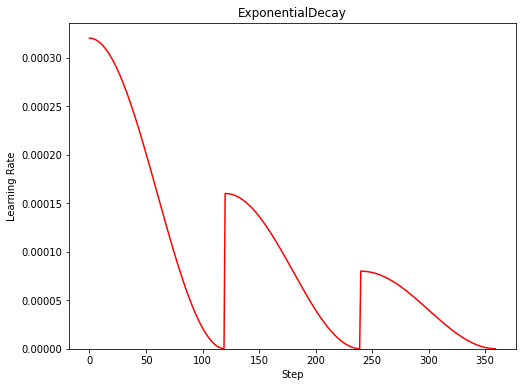

In [ ]:

count=count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE //100
N = count*config.EPOCHS
step = config.EPOCHS//3
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate = 0.000005 * config.BATCH_SIZE,
    first_decay_steps = count*step,	# 当前全局iter迭代次数，传入一个递增的variable
    t_mul=1.0,	# 后续的warm restarts衰减周期相较于前一次的倍率（周期越来越长）
    m_mul=0.5,	# 每一次warm restarts学习率峰值的改变
    alpha=0.000001,	# 学习率到最小衰减到多少
)

y = []
for global_step in range(N):
	lr = lr_schedule(global_step) 
	y.append(lr)
x = range(N) 
plt.figure(figsize=(8,6)) 
plt.plot(x, y, 'r-')
plt.ylim([0,max(plt.ylim())]) 
plt.xlabel('Step') 
plt.ylabel('Learning Rate') 
plt.title('ExponentialDecay') 
plt.show()

In [ ]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]
#from classification_models.keras import Classifiers
#model, preprocess_input = Classifiers.get('resnet34')
def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model(count = 0):

    if config.head=='arcface':
      head = ArcMarginProduct
    elif config.head=='arcface_subcenter':
      head = ArcMarginProduct_subcenter
    elif config.head=='curricularface':
      head = CurricularFace
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30, 
            m = 0.3, 
            name=f'head/{config.head}', 
            dtype='float32'
            )


        # inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')

        if config.model_type == 'effnetv1':
            # x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            # embed = tf.keras.layers.GlobalAveragePooling2D()(x)
            inp = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False,input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])
            inp.layers[0]._name = 'inp1'

            def GEM_Pooling(x,size=24):
              x=GeM(size)(x)
              x= tf.keras.layers.Flatten()(x)
              # x = tf.keras.layers.BatchNormalization()(x)
              # x = tf.keras.activations.swish(x)
              return x
            '''effnet-b5'''
            # x1=GEM_Pooling(inp.layers[-1].output,24)
            # x2=GEM_Pooling(inp.layers[-4].output,24) 
            # x3=GEM_Pooling(inp.layers[-47].output,24)
            # x4=GEM_Pooling(inp.layers[-180].output,48)
            # x5=GEM_Pooling(inp.layers[-283].output,48)

            '''effnet-b6'''
            x1=GEM_Pooling(inp.layers[-1].output,inp.layers[-1].output.shape[-2])
            x2=GEM_Pooling(inp.layers[-4].output,inp.layers[-4].output.shape[-2]) 
            x3=GEM_Pooling(inp.layers[-47].output,inp.layers[-47].output.shape[-2])
            x4=GEM_Pooling(inp.layers[-210].output,inp.layers[-210].output.shape[-2])
            x5=GEM_Pooling(inp.layers[-328].output,inp.layers[-328].output.shape[-2])

            '''effnet-b7'''
            # x1=GEM_Pooling(inp.layers[-1].output,24)
            # x2=GEM_Pooling(inp.layers[-4].output,24)
            # x3=GEM_Pooling(inp.layers[-62].output,24)
            # x4=GEM_Pooling(inp.layers[-270].output,48)
            # x5=GEM_Pooling(inp.layers[-403].output,48)

            embed = tf.concat([x1,x2,x3,x4,x5],axis = 1)
            # embed = tf.concat([x1,x3,x4,x5],axis = 1)
            # embed = x1
            # embed = tf.nn.l2_normalize(embed, 1)
            embed = tf.keras.layers.BatchNormalization()(embed)
            embed = tf.keras.activations.swish(embed)
            # print(embed)

        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
        else:
            embed = tfimm.create_model(config.model_type, pretrained="timm")(inp)
            #embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        

        # embed = tf.keras.layers.Dropout(0.2)(embed)
        # embed = tf.keras.layers.Dense(512)(embed)
        embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(2048)(embed)
        embed = tf.keras.layers.BatchNormalization()(embed)
        # print(test_embed)

        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp.input, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp.input, outputs = embed) 

        count=count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE 
        step = config.EPOCHS//3
        lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate = 0.000005 * config.BATCH_SIZE,
            first_decay_steps = count*step,	# 当前全局iter迭代次数，传入一个递增的variable
            t_mul=1.0,	# 后续的warm restarts衰减周期相较于前一次的倍率（周期越来越长）
            m_mul=0.5,	# 每一次warm restarts学习率峰值的改变
            alpha=0.000001,	# 学习率到最小衰减到多少
            )
        # opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
        # lr_decayed_fn = tf.keras.experimental.CosineDecay(0.000001, count)
        # opt = tfa.optimizers.AdamW(weight_decay=0.0002,learning_rate=lr_schedule)

        
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

1e-05
8.75e-05
0.000165
0.0002425
0.00032
0.0002881
0.00025939
0.00023355100000000003
0.0002102959
0.00018936631
0.00017052967900000002
0.00015357671110000003
0.00013831903999000003
0.00012458713599100001
0.00011222842239190003
0.00010110558015271001
9.109502213743904e-05
8.208551992369512e-05
7.397696793132561e-05
6.667927113819305e-05
6.011134402437375e-05
5.4200209621936375e-05
4.8880188659742735e-05
4.4092169793768466e-05
3.978295281439162e-05
3.590465753295246e-05
3.241419177965722e-05
2.9272772601691496e-05
2.6445495341522345e-05
2.390094580737011e-05
2.16108512266331e-05
1.9549766103969792e-05
1.7694789493572816e-05
1.6025310544215532e-05
1.452277948979398e-05
1.3170501540814584e-05
1.1953451386733124e-05
1.085810624805981e-05
9.87229562325383e-06
8.985066060928449e-06
8.186559454835603e-06
7.467903509352042e-06
6.821113158416839e-06
6.239001842575155e-06
5.7151016583176395e-06
5.243591492485875e-06
4.819232343237288e-06
4.437309108913559e-06
4.093578198022204e-06
3.784220378219

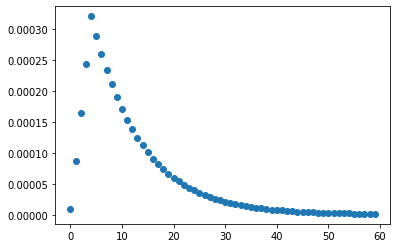

In [ ]:
def get_lr_callback(plot=False):
    lr_start   = 0.00001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        print(lr)  
        return lr
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [ ]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Train

In [ ]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [ ]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model(count = count)
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()
# model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5")
if config.RESUME:   
    model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5")

165240832/165226952 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 320, 320, 56  1512        ['inp1[0][0]']                   
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 320, 320, 56  224         ['stem_conv[0][0]']              
                           

In [ ]:
import gc
gc.collect()

476

In [ ]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (config.IMAGE_SIZE,config.EFF_NET,config.BATCH_SIZE))

#### Image Size 640 with EfficientNet B6 and batch_size 64


In [ ]:
history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                # shuffle = True,
                # workers=4,
                # use_multiprocessing=True,
                callbacks = [snap,train_logger,sv_loss], 
                verbose = VERBOSE)

Epoch 1/60
  6/637 [..............................] - ETA: 9:56 - loss: 18.6724 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0166s vs `on_train_batch_end` time: 23.3716s). Check your callbacks.


637/637 [==============================] - 1081s 1s/step - loss: 16.9027 - sparse_categorical_accuracy: 1.7170e-04 - sparse_top_k_categorical_accuracy: 4.9058e-04 - val_loss: 15.9649 - val_sparse_categorical_accuracy: 0.0023 - val_sparse_top_k_categorical_accuracy: 0.0040
Epoch 2/60
637/637 [==============================] - 741s 1s/step - loss: 14.4865 - sparse_categorical_accuracy: 0.0126 - sparse_top_k_categorical_accuracy: 0.0268 - val_loss: 13.8361 - val_sparse_categorical_accuracy: 0.0535 - val_sparse_top_k_categorical_accuracy: 0.0951
Epoch 3/60
637/637 [==============================] - 740s 1s/step - loss: 11.7951 - sparse_categorical_accuracy: 0.0552 - sparse_top_k_categorical_accuracy: 0.0940 - val_loss: 12.2220 - val_sparse_categorical_accuracy: 0.1423 - val_sparse_top_k_categorical_accuracy: 0.2012
Epoch 4/60
637/637 [==============================] - 738s 1s/step - loss: 9.4372 - sparse_categorical_accuracy: 0.1076 - sparse_top_k_categorical_accuracy: 0.1638 - val_loss: 1

In [ ]:
model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss_{config.FOLD_TO_RUN}.h5")
# model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss_0.h5")
# model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

## Evaluation

In [ ]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    TTA = ['rotate0', 'rotate0_lr']
    for i,tta in enumerate(TTA):
      ds = get_test_dataset([filename],get_names=False,tta = tta)
      if i==0:
        test_embeddings=normalize(embed_model.predict(ds,verbose=0),axis=1)
      else:
        test_embeddings+=normalize(embed_model.predict(ds,verbose=0),axis=1)
    test_embeddings = normalize(test_embeddings,axis=1)
    return test_embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ("/content/drive/MyDrive/model/individual_ids.json", "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
train_targets = []
train_embeddings = []
train_data_list=[] 

for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'train_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings)    
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
    train_data_list.append([filename,embeddings])
train_embeddings_df = pd.DataFrame(train_data_list, columns=['filename', 'embeddings'])
train_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
train_embeddings_df.to_csv(config.save_dir+f"/train_embeddings_{config.FOLD_TO_RUN}.csv",index=False)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [ ]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
val_data_list=[] 
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'val_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings) 
    val_data_list.append([filename,embeddings])
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
val_embeddings_df = pd.DataFrame(val_data_list, columns=['filename', 'embeddings'])
val_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
val_embeddings_df.to_csv(config.save_dir+f"/val_embeddings_{config.FOLD_TO_RUN}.csv",index=False)

test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    1889
37c7aba965a5        80
114207cab555        34
a6e325d8e924        31
19fbb960f07d        31
                  ... 
76519fee24c2         1
d449cbda2335         1
de30db440d1d         1
d8a08bac71b8         1
563d94c3c7a5         1
Name: target, Length: 3982, dtype: int64

In [ ]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv(config.save_dir+f'val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/10205 [00:00<?, ?it/s]

1      549
35     191
34     186
25     184
36     184
      ... 
99       3
97       2
95       2
94       2
100      1
Name: image, Length: 99, dtype: int64

In [ ]:
## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.0: 0.7659496978605235


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.1: 0.7659496978605235


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.2: 0.7659496978605235


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.7659986934509203


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.4: 0.7788845337252954


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.5: 0.8257243181446976


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.8180320104523897


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.7805993793891856


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.8: 0.7261652784582695


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 0.9: 0.6348864935489119


0it [00:00, ?it/s]

  0%|          | 0/10205 [00:00<?, ?it/s]

CV at threshold 1.0: 0.5290560182916856


In [ ]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.5
Best cv 0.8257243181446976


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
count,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000
mean,0.765950,0.765950,0.765950,0.765999,0.778885,0.825724,0.818032,0.780599,0.726165,0.634886,0.529056
std,0.350489,0.350489,0.350489,0.350487,0.349661,0.342582,0.344192,0.349515,0.350042,0.331428,0.272537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 8316, True: 1889}
best_threshold 0.5


is_new_individual,False,True,adjusted_cv
0.0,0.826361,0.500000,0.793725
0.1,0.826361,0.500000,0.793725
0.2,0.826361,0.500000,0.793725
0.30000000000000004,0.826361,0.500265,0.793751
0.4,0.825519,0.573584,0.800326
0.5,0.813193,0.880889,0.819963
0.6000000000000001,0.781147,0.980413,0.801073
0.7000000000000001,0.732085,0.994177,0.758294
0.8,0.664264,0.998677,0.697705
0.9,0.552070,0.999471,0.596810


## Inference

In [ ]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51026, 2048) (51026,)


In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [ ]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
test_data_list=[] 
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    with open(config.save_dir+f'test_{filename.split("/")[-1]}_{config.FOLD_TO_RUN}.npy', 'wb') as f:
      np.save(f, embeddings) 
    test_data_list.append([filename,embeddings])
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)

test_embeddings_df = pd.DataFrame(test_data_list, columns=['filename', 'embeddings'])
test_embeddings_df['FOLD_TO_RUN']=config.FOLD_TO_RUN
test_embeddings_df.to_csv(config.save_dir+f"/test_embeddings_{config.FOLD_TO_RUN}.csv",index=False)



test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/model/sample_submission.csv",index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv(config.save_dir+f'test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

1      539
34     534
33     533
27     525
32     520
      ... 
97      19
99      12
96      10
100      9
95       5
Name: image, Length: 100, dtype: int64

In [ ]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(config.save_dir+f"/submission_origin.csv",index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,d43a1cced26011.jpg,982224d06f8c new_individual 197df8b4dfd4 66423...
1,16e54246f763f8.jpg,2e268c8dbd31 new_individual f8d95c7b3fa6 66423...
2,7a785b700b0339.jpg,c93996835aa8 new_individual 39af37a7f933 5ba5d...
3,bca078236816bb.jpg,84a261c0e5cf new_individual 84502c5db6bc 8274d...
4,68127bda005a60.jpg,f17a28521e9d new_individual 51081e431bca 7d07b...


In [ ]:
predictions

,image,predictions
0,d43a1cced26011.jpg,982224d06f8c new_individual 197df8b4dfd4 66423...
1,16e54246f763f8.jpg,2e268c8dbd31 new_individual f8d95c7b3fa6 66423...
2,7a785b700b0339.jpg,c93996835aa8 new_individual 39af37a7f933 5ba5d...
3,bca078236816bb.jpg,84a261c0e5cf new_individual 84502c5db6bc 8274d...
4,68127bda005a60.jpg,f17a28521e9d new_individual 51081e431bca 7d07b...
...,...,...
27951,c13e472b934456.jpg,new_individual f263fb6c725a 929a6eff10e6 eedd9...
27952,70aaad4558a406.jpg,new_individual 7485701415cd cc0e0b020a90 2b50f...
27953,c47a9d49be08a4.jpg,new_individual c5e24731f051 1049f2e21c21 92136...
27954,5abd96ae2f3ba2.jpg,new_individual 99fa675295a1 edf59f267081 21637...


In [ ]:
# df2 = pd.read_csv("/content/drive/MyDrive/backfin/submission_772.csv")
# ids = np.load("/content/drive/MyDrive/backfin/ids_without_backfin.npy", allow_pickle = True) #whales without backfins determined with a simple classifier

In [ ]:
# df2

In [ ]:
# ids2 = df2["image"][~df2["image"].isin(predictions["image"])] #images without a bounding box

In [ ]:
# submission = pd.concat([
#     predictions[~(predictions["image"].isin(ids))],
#     df2[df2["image"].isin(ids)],
#     df2[df2["image"].isin(ids2)]
# ])

In [ ]:
# submission

In [ ]:
# submission = submission.drop_duplicates()

In [ ]:
# submission.to_csv(config.save_dir+f"/submission.csv",index=False)
# submission.head()